# Import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

# Dataset

## Dataset load

In [3]:
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

## 데이터셋 크기
- 7,481개의 학습 데이터(training data)
- 711개의 평가용 데이터(test data)
- 423개의 검증용 데이터(validation data)

## 데이터 확인

In [5]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-1.75,  0.7 ,  0.57, -2.71, -2.7 , -1.75, -1.7 , -2.94,  0.17,
       -1.64], dtype=float32)>, 'bbox': <tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0.23509334, 0.56614333, 0.53874665, 0.68377614],
       [0.04008   , 0.        , 0.47984   , 0.18144928],
       [0.1736    , 0.02102255, 0.49045333, 0.2610145 ],
       [0.24208   , 0.06778583, 0.51104   , 0.30534622],
       [0.29738668, 0.15386474, 0.49738666, 0.32354268],
       [0.35154667, 0.5439211 , 0.5119733 , 0.6158776 ],
       [0.41018668, 0.52661836, 0.5322667 , 0.56783414],
       [0.41416   , 0.32743156, 0.5397867 , 0.39668277],
       [0.4344    , 0.36307567, 0.51344   , 0.42380032],
       [0.45402667, 0.51460546, 0.5219733 , 0.53947663]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1.66, 1.74, 3.65],
       [1.52, 1.49, 3.5 ],
       [1.49, 1

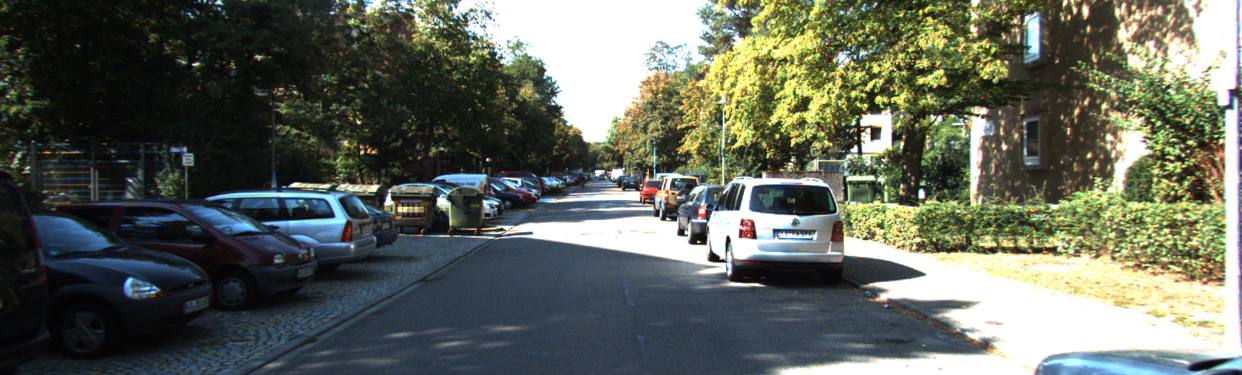

In [6]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

## 데이터 설명
<pre>
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',   
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',   
                     'Misc' or 'DontCare'   
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where   
                     truncated refers to the object leaving image boundaries   
   1    occluded     Integer (0,1,2,3) indicating occlusion state:   
                     0 = fully visible, 1 = partly occluded   
                     2 = largely occluded, 3 = unknown   
   1    alpha        Observation angle of object, ranging [-pi..pi]   
   4    bbox         2D bounding box of object in the image (0-based index):   
                     contains left, top, right, bottom pixel coordinates   
   3    dimensions   3D object dimensions: height, width, length (in meters)   
   3    location     3D object location x,y,z in camera coordinates (in meters)   
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]   
   1    score        Only for results: Float, indicating confidence in   
                     detection, needed for p/r curves, higher is better.   
</pre>

# Dataset preprocessing

<code>bbox = left, top, right, bottom pixel
x_min = top, x_max = bottom|
y_min = h - left, y_max = h - right</code>

## Training dataset

In [8]:
import os
data_dir = '/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/data'
img_dir = '/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/data/kitti_images/'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }

    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        # 코드 구현
        # image, filename, objects
        filename = item["image/file_name"].numpy().decode('utf-8')
        img_path = img_dir + filename
        
        image = Image.fromarray(item["image"].numpy())
        if not os.path.exists(img_path):
            image.save(img_path)
        objects = item["objects"]
        
        # 좌표 계산
        w, h = image.size[:2]
        coordinate = objects['bbox'].numpy()
        x_a, x_b = coordinate[:, 1]*w, coordinate[:, 3]*w,
        y_a, y_b = h - coordinate[:, 2]*h, h - coordinate[:, 0]*h
        rects = np.stack([x_a, y_a, x_b, y_b], axis=1).astype(np.int)

        # class_types list
        class_types = objects['type'].numpy()
        
#         tmp = []
        for i, rect in enumerate(rects):
            _type = class_types[i]
            if _type not in type_class_map.keys():
                continue
            dict_ = {}
            dict_['img_path'] = img_dir + filename
            dict_['x1'] = rect[0]
            dict_['y1'] = rect[1]
            dict_['x2'] = rect[2]
            dict_['y2'] = rect[3]
            dict_['class_name'] = type_class_map[class_types[i]]
#             tmp.append(dict_)
            df = df.append(dict_, ignore_index=True)
#     print(df)
    return df

if not os.path.exists(train_csv_path):
    df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
    df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

## Test dataset

In [9]:
test_csv_path = data_dir + '/kitti_test.csv'

if not os.path.exists(test_csv_path):
    df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
    df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

## Class list

In [10]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    # 코드 구현
    class_type_num = {
        'car': 0,
        'person': 1
    }
    with open(path, 'w', encoding='utf-8') as f:
        for k, v in class_type_num.items():
            f.write(f'{k},{v}\n')

save_class_format(class_txt_path)

# Training

In [11]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다.
if not os.path.exists('./snapshots/resnet50_csv_50.h5'):
    !python ~/aiffel/Going_Deeper/3.object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv /home/aiffel0049/aiffel/Going_Deeper/3.object_detection/data/kitti_train.csv ~/aiffel/Going_Deeper/3.object_detection/data/classes.txt

# Testing

- Convert resnet50_csv_50.h5 to for inferencing model

In [12]:
!retinanet-convert-model /home/aiffel0049/aiffel/Going_Deeper/3.object_detection/snapshots/resnet50_csv_50.h5 /home/aiffel0049/aiffel/Going_Deeper/3.object_detection/snapshots/resnet50_csv_50_infer.h5

2020-11-05 15:06:44.691632: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-05 15:06:45.488959: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-05 15:06:45.509076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-05 15:06:45.509394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-05 15:06:45.509409: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-05 15:06:45.510357: I tensorflow/stream_executor/platform

## import for test

In [13]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)


model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Using TensorFlow backend.


Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


## autonomous drive system function

[770.73846 143.71938 844.2422  315.81702] 0.9033659 1
73.50372 172.09764
[773.49194 144.29723 843.00977 308.15228] 0.16383791 0


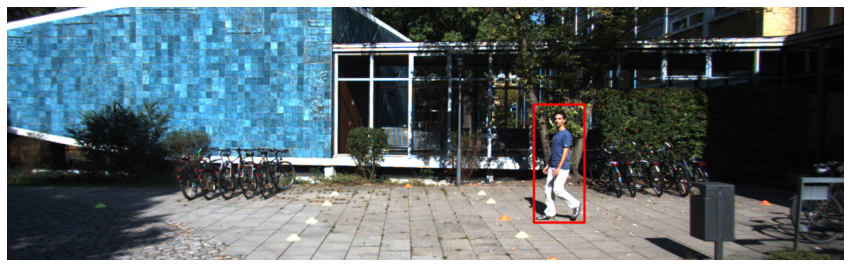

Stop
Stop


In [14]:
img_path = '/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"


    image = read_image_bgr(img_path)

    # TODO: copy image to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0:(0, 0, 255),  # blue, car
        1:(255, 0, 0)  # red, person
    }
    # TODO: preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    # TODO: process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # TODO: correct for image scale
    boxes /= scale
    
    result = 'Go'
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        print(box, score, label)
        if score < 0.5:
            break
        b = box.astype(int)
        draw_box(draw, b, color=color_map[label])
        
        w = box[2] - box[0]
        h = box[3] - box[1]
        print(w,h)
        if label == 1 or (label==0 and (w >= size_limit or h >= size_limit)):
            result = 'Stop'

    plt.figure(figsize = (15,15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    print(result)
    return result

print(self_drive_assist(img_path))    

## Autonomous drive System Test

/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/stop_1.png
[770.73846 143.71938 844.2422  315.81702] 0.9033659 1
73.50372 172.09764
[773.49194 144.29723 843.00977 308.15228] 0.16383791 0


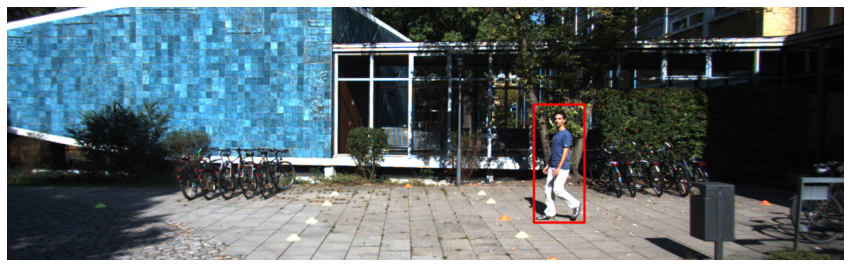

Stop
/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/stop_2.png
[410.60562 167.65872 499.44098 328.92972] 0.9366506 1
88.83536 161.271
[408.32843 168.59341 505.66492 330.36978] 0.3164886 0


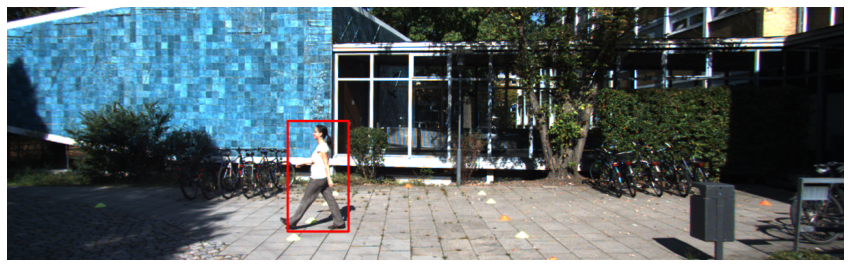

Stop
/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/stop_3.png
[755.76056 159.88478 886.70465 210.46172] 0.9711586 0
130.94409 50.576935
[  3.579409 200.6467   314.91953  369.12827 ] 0.96708363 0
311.34012 168.48157
[ 990.3431   147.12677 1029.8949   215.01839] 0.76739436 1
39.55182 67.89162
[491.5323  173.89595 526.6984  194.85684] 0.25280535 0


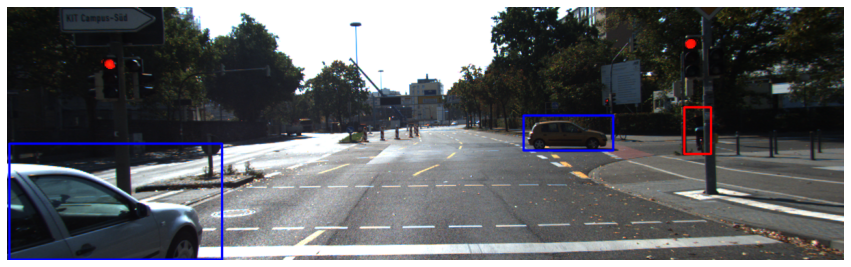

Stop
/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/stop_4.png
[ 724.7095     60.250412 1141.8845    361.2172  ] 0.99652773 0
417.17505 300.9668
[657.0402  142.20097 742.1542  229.6027 ] 0.97169715 0
85.11395 87.40173
[  1.5933408 151.33514   375.16925   311.5605   ] 0.9688116 0
373.5759 160.22534
[351.45462 174.6878  476.8763  220.79312] 0.93470687 0
125.42169 46.105316
[444.66956 157.8407  554.9229  205.00354] 0.91852754 0
110.25336 47.16284
[673.87256 146.3779  785.37573 246.73389] 0.6588874 0
111.503174 100.35599
[380.08612 167.12215 518.58966 215.98502] 0.59029776 0
138.50354 48.86287
[126.8098  165.32858 382.2897  278.02502] 0.38151756 0


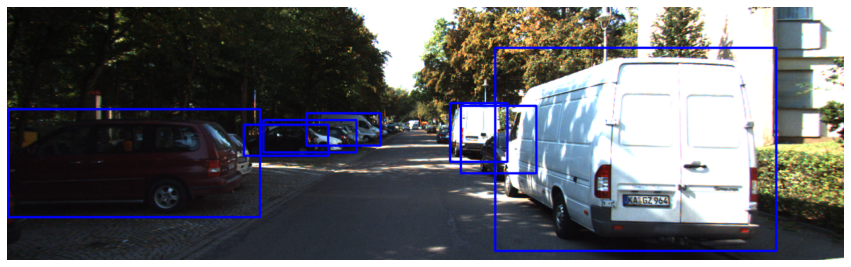

Stop
/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/stop_5.png
[ 882.8317   174.64761 1241.0684   373.6249 ] 0.9962288 0
358.23663 198.9773
[704.04596 134.78302 777.8449  213.79395] 0.9763906 0
73.79895 79.010925
[734.2335  165.02698 862.22003 246.02771] 0.956127 0
127.98651 81.00073
[566.2366  180.4665  616.97217 215.36113] 0.9527237 0
50.735596 34.894623
[709.5851  141.10982 816.9847  227.14763] 0.7407373 0
107.3996 86.03781
[584.1867  177.03606 628.1531  208.7057 ] 0.6995031 0
43.96637 31.669647
[599.8347  176.03035 632.9479  202.16876] 0.31017902 0


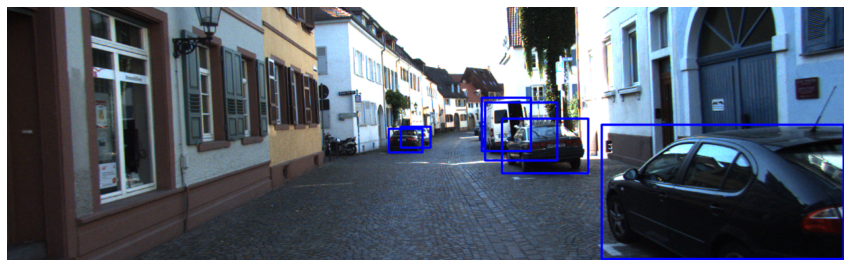

Stop
/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/go_1.png
[192.82245 134.65948 358.29633 232.81595] 0.9831078 0
165.47388 98.15646
[593.43677 174.65504 625.45984 206.13101] 0.97814023 0
32.02307 31.475967
[374.55106 184.81648 416.64554 208.05188] 0.90464985 0
42.094482 23.235397
[665.9963  160.70413 728.17706 192.8497 ] 0.66230774 0
62.180786 32.14557
[441.59064 172.8302  472.63873 197.42387] 0.5395789 0
31.048096 24.593674
[534.515   160.24278 563.60455 190.03915] 0.44030684 0


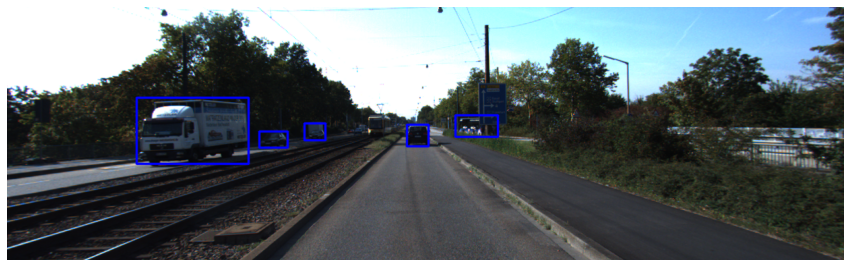

Go
/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/go_2.png
[514.18585 179.5973  569.5286  215.26288] 0.98825943 0
55.342773 35.665573
[628.779   173.50934 666.99365 213.91995] 0.9852337 0
38.21466 40.410614
[528.37244 175.97778 579.5241  208.15588] 0.5361354 0
51.151672 32.1781
[562.5623  172.00888 594.4425  195.38005] 0.47487172 0


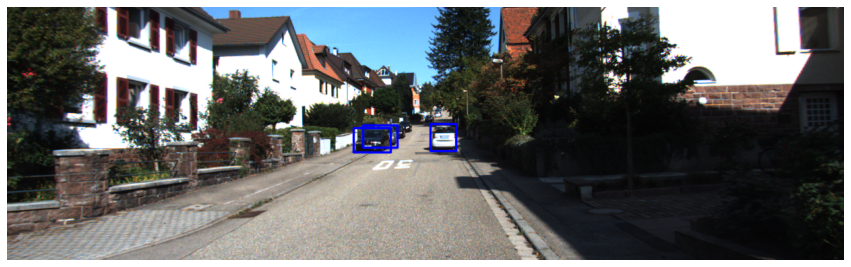

Go
/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/go_3.png
[822.9347  148.70074 896.4202  174.09502] 0.8398523 0
73.485535 25.394272
[542.3137  167.11388 570.0063  189.07896] 0.6953365 0
27.692566 21.965088
[  0.       179.8022    45.624603 235.00806 ] 0.25630957 0


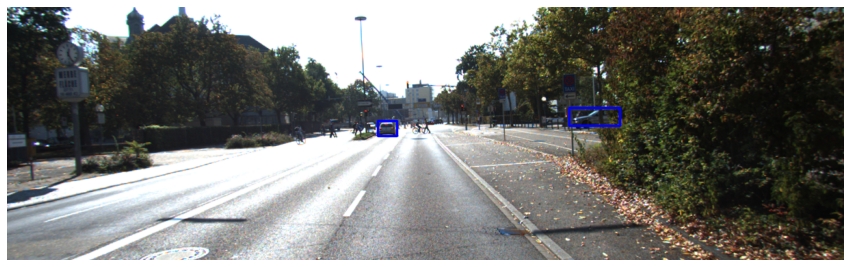

Go
/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/go_4.png
[694.46466 174.45871 794.59174 252.45268] 0.9975598 0
100.127075 77.99397
[720.62067 144.52585 760.6548  179.95116] 0.29298833 0


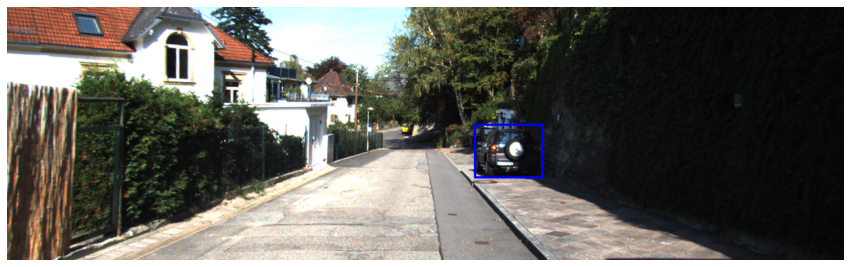

Go
/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/test_set/go_5.png
[  0.      190.71259 221.50322 305.29248] 0.98669493 0
221.50322 114.579895
[147.9228  179.67168 343.03265 255.75385] 0.9667149 0
195.10985 76.08217
[324.32425 178.6358  433.37918 225.11365] 0.776629 0
109.05493 46.477844
[444.46774 179.55672 488.0977  209.45316] 0.71370643 0
43.629944 29.896439
[ 54.653004 185.57697  309.58734  269.98883 ] 0.6653217 0
254.93434 84.411865
[223.2607  176.43764 372.76114 234.19554] 0.5724448 0
149.50044 57.757904
[273.5762  178.61447 396.33884 226.06123] 0.55212855 0
122.762634 47.446762
[1091.8118   142.88536 1241.0684   204.67844] 0.5316913 0
149.25659 61.793076
[649.0422  170.84447 673.97644 193.51663] 0.50232923 0
24.934265 22.672165
[485.11588 178.08774 521.9276  202.42221] 0.47834095 0


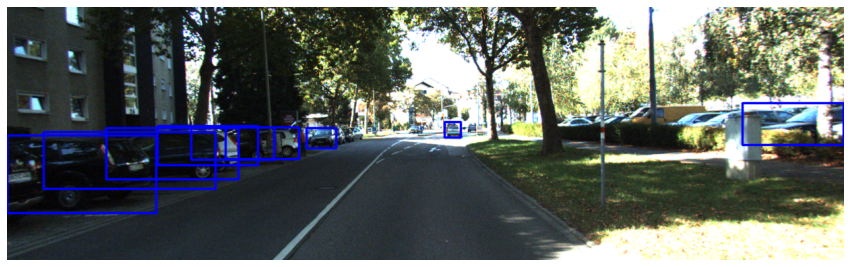

Go
100점입니다.


In [15]:
import os

def test_system(func):
    work_dir = '/home/aiffel0049/aiffel/Going_Deeper/3.object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

# 결론

- 테스트 수행결과 100%의 정확도를 얻음